In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input
from keras.models import Model

import omnifold6b as of

import tensorflow as tf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.21.5
  tensorflow version:  2.11.0





## Set model and resolution parameters

In [3]:
ndim = 4



train_mu = [ 1.,  0.,  -0.5,   0.5 ]


#--- determinant is negative
#train_rho = [ 
#              [0.3, -0.2, 0.1   ],  #0
#              [-0.5, 0.1],  #1
#              [0.7],  #2
#            ]

#--- determinant positive, bad1a
#train_rho = [ 
#              [0.3, -0.2, 0.1   ],  #0
#              [-0.4, 0.1],  #1
#              [0.7],  #2
#            ]

#--- determinant positive, bad1a
train_rho = [ 
              [0.3, -0.2, 0.1   ],  #0
              [0.0, 0.1],  #1
              [0.7],  #2
            ]






train_sig = [ 1., 0.7, 1.1, 0.8 ]





true_mu = [ 0.8,  0.1,  -0.6, 0.7 ]


#--- used in old prod and in bad1a
#true_rho  = [ 
#              [0.4, -0.3, 0.0   ],  #0
#              [-0.4, 0.2],  #1
#              [0.5],  #2
#            ]


true_rho  = [ 
              [0.4, -0.3, 0.0   ],  #0
              [0.0, 0.2],  #1
              [0.5],  #2
            ]



true_sig = [ 0.8, 0.6, 1.0,    0.6 ]



#--- nominal
#resolution = [ 0.4, 0.5, 0.6,   0.3  ]

#--- poor
resolution = [ 0.8, 1.0, 1.2,   0.6  ]


train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                
ngen_train = 100000
ngen_true =  10000



ngen_train = 1000000
ngen_true =  100000


ngen_train = 4000000
ngen_true =  400000




of_niter = 20

learning_rate_setval = 0.0005


epochs_setval = 40

batch_size_setval = int( ngen_true )



output_dir = 'toy-study6b-4d-pdcov'

save_step2_model = True





 Train covariance:
   0,  0 : diagonal    1.0000
   0,  1 :              1.000 *    0.700 *    0.100 =   0.0700
   0,  2 :              1.000 *    1.100 *   -0.200 =  -0.2200
   0,  3 :              1.000 *    0.800 *    0.300 =   0.2400
   1,  1 : diagonal    0.4900
   1,  2 :              0.700 *    1.100 *    0.100 =   0.0770
   1,  3 :              0.700 *    0.800 *    0.000 =   0.0000
   2,  2 : diagonal    1.2100
   2,  3 :              1.100 *    0.800 *    0.700 =   0.6160
   3,  3 : diagonal    0.6400



 True covariance:
   0,  0 : diagonal    0.6400
   0,  1 :              0.800 *    0.600 *    0.000 =   0.0000
   0,  2 :              0.800 *    1.000 *   -0.300 =  -0.2400
   0,  3 :              0.800 *    0.600 *    0.400 =   0.1920
   1,  1 : diagonal    0.3600
   1,  2 :              0.600 *    1.000 *    0.200 =   0.1200
   1,  3 :              0.600 *    0.600 *    0.000 =   0.0000
   2,  2 : diagonal    1.0000
   2,  3 :              1.000 *    0.600 *    0.500 = 

In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()



 Output directory already exists:  toy-study6b-4d-pdcov


In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  0.103819
True covariance determinant:   0.028732





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[ 1.     0.07  -0.22   0.24 ]
 [ 0.07   0.49   0.077  0.   ]
 [-0.22   0.077  1.21   0.616]
 [ 0.24   0.     0.616  0.64 ]]

 Train covariance inverse
[[ 1.82748538 -0.48036759  1.39553429 -2.02850877]
 [-0.48036759  2.2079007  -0.62656642  0.78320802]
 [ 1.39553429 -0.62656642  2.71857329 -3.13995215]
 [-2.02850877  0.78320802 -3.13995215  5.34539474]]

 Train covariance inverse test
[[ 1.00000000e+00 -1.13971767e-17  1.12265327e-16  1.74567962e-16]
 [-2.67694780e-17  1.00000000e+00  2.39091527e-17 -1.84557314e-17]
 [ 3.83920965e-16 -7.68708405e-17  1.00000000e+00 -3.09182504e-16]
 [ 2.31004300e-17  4.85381715e-17 -1.74023475e-17  1.00000000e+00]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[ 0.64   0.    -0.24   0.192]
 [ 0.     0.36   0.12   0.   ]
 [-0.24   0.12   1.     0.3  ]
 [ 0.192  0.     0.3    0.36 ]]

 True covariance inverse
[[ 3.20258372 -0.60142417  1.80427252 -3.21160508]
 [-0.60142417  3.04721581 -0.80831409  0.99435463]
 [ 1.80427252 -0.80831409  2.42494226 -2.9830639 ]
 [-3.21160508  0.99435463 -2.9830639   6.9765204 ]]

 True covariance inverse test
[[ 1.00000000e+00 -2.48915592e-17  4.49207005e-17  3.14364906e-17]
 [-1.24534717e-17  1.00000000e+00  1.58764457e-17 -6.73654956e-18]
 [ 2.35496123e-16 -1.10395541e-17  1.00000000e+00  1.13629062e-17]
 [-1.61493862e-16  8.95699561e-18 -7.57207999e-17  1.00000000e+00]]





## Plots to visualize these parameter choices

In [12]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



In [13]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

/usr/lib/python3/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )


config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : toy-study6b-4d-pdcov/config.txt

2023-12-11 14:16:03.651114

ngen_train 4000000
ngen_true  400000
of_niter   20
ndim       4
learning_rate_setval  0.000500
epochs_setval  40
batch_size_setval  400000


train_mu : [1.0, 0.0, -0.5, 0.5]
train_rho : [[0.3, -0.2, 0.1], [0.0, 0.1], [0.7]]
train_sig : [1.0, 0.7, 1.1, 0.8]
train_cov : [[ 1.     0.07  -0.22   0.24 ]
 [ 0.07   0.49   0.077  0.   ]
 [-0.22   0.077  1.21   0.616]
 [ 0.24   0.     0.616  0.64 ]]


true_mu : [0.8, 0.1, -0.6, 0.7]
true_rho : [[0.4, -0.3, 0.0], [0.0, 0.2], [0.5]]
true_sig : [0.8, 0.6, 1.0, 0.6]
true_cov : [[ 0.64   0.    -0.24   0.192]
 [ 0.     0.36   0.12   0.   ]
 [-0.24   0.12   1.     0.3  ]
 [ 0.192  0.     0.3    0.36 ]]


resolution : [0.8, 1.0, 1.2, 0.6]





<function matplotlib.pyplot.show(close=None, block=None)>

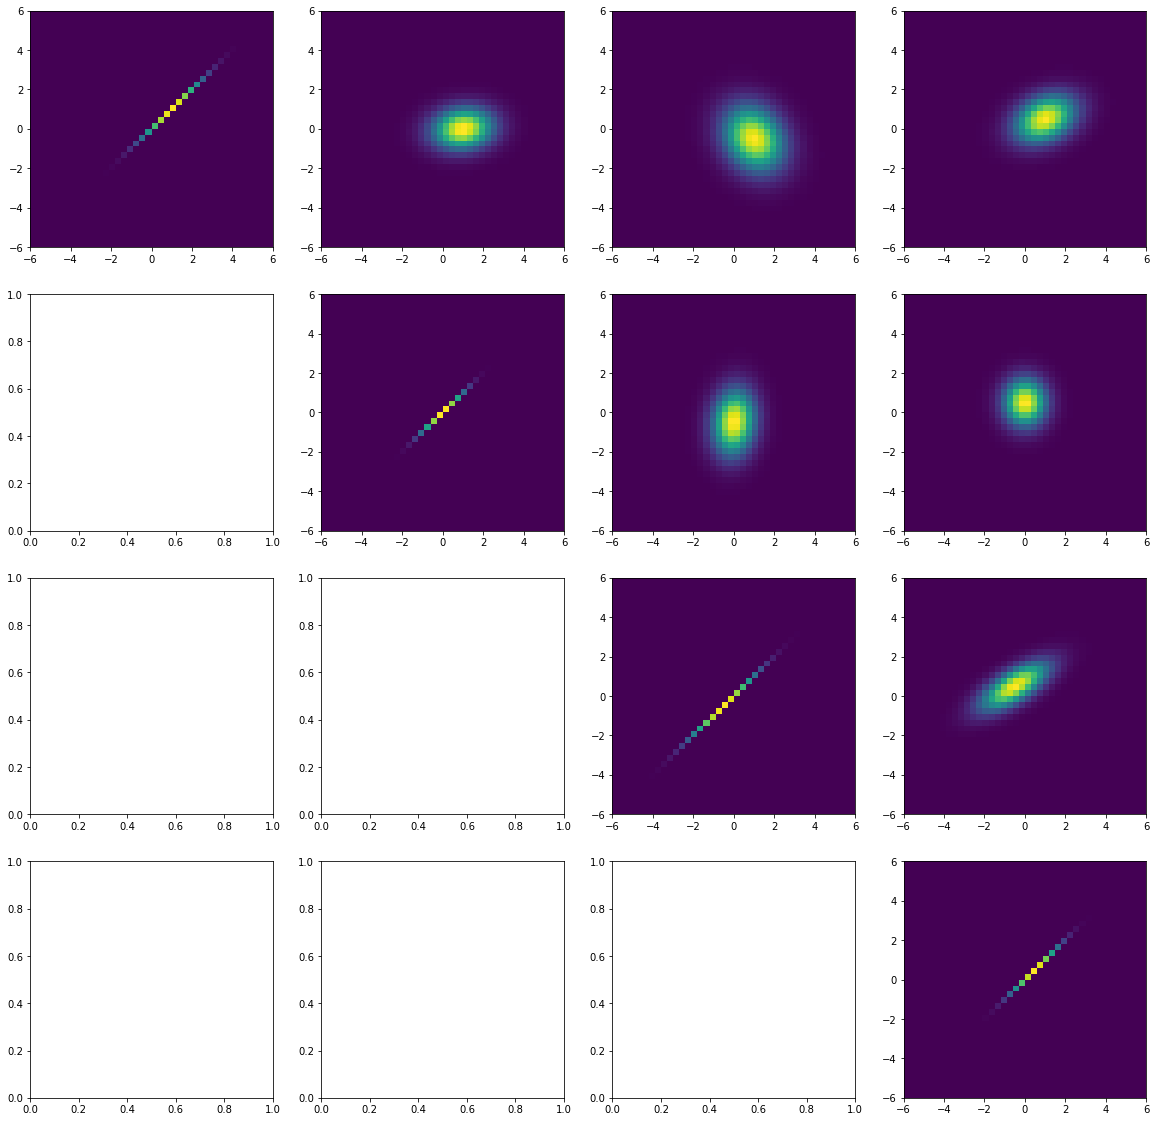

In [16]:
fig,ax = plt.subplots( 4, 4, figsize=(20,20))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

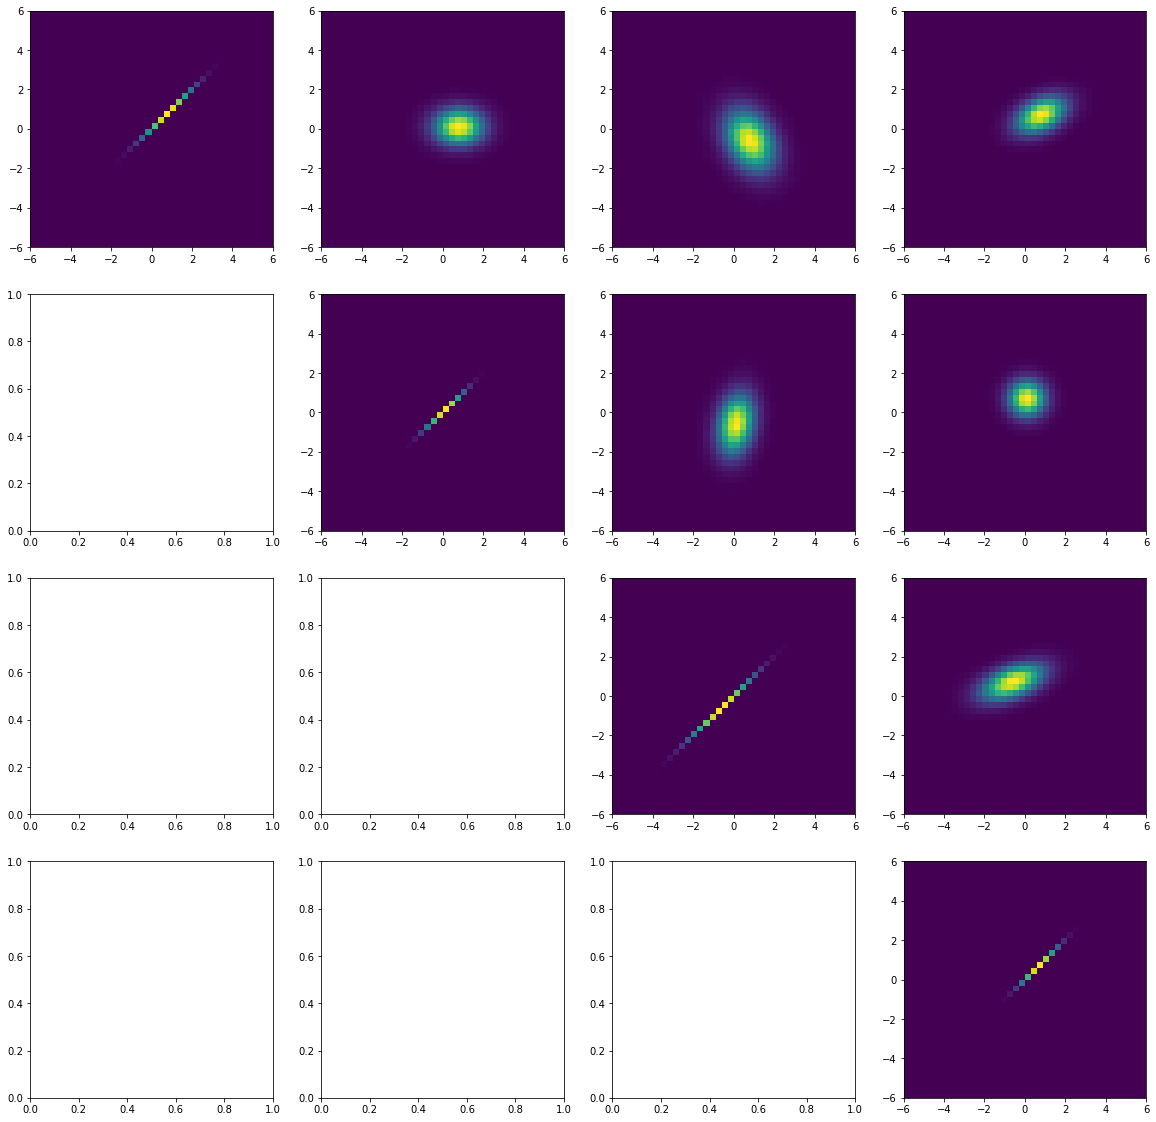

In [17]:
fig,ax = plt.subplots( 4, 4, figsize=(20,20))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

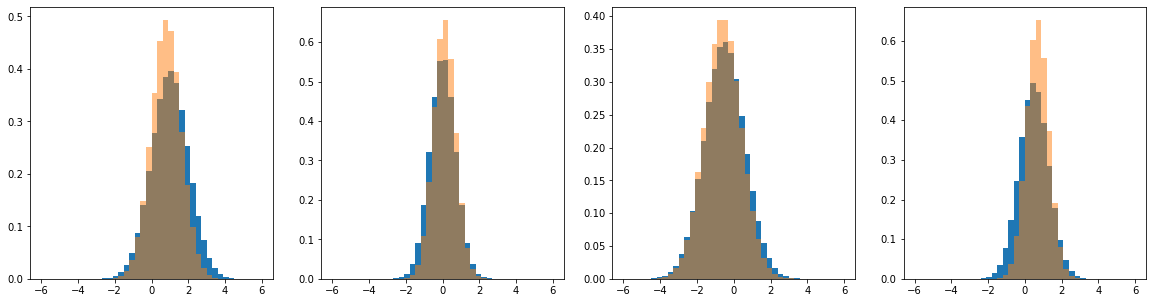

In [18]:
fig,ax = plt.subplots( 1, 4, figsize=(20,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        ax[i].hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

## Set up NN model for OmniFold

In [19]:
inputs = Input((4, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2023-12-11 14:16:07.948862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-11 14:16:07.974623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-11 14:16:07.974920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-11 14:16:07.978764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-11 14:16:07.979009: I tensorflow/compiler/xla/stream_executo

## Package the training data for OmniFold

In [20]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [21]:
%%time


verbose = True






of_return_dict = of.omnifold6b( 
    train_both, true_det_pts, of_niter, model, verbose, 
    batch_size_setval, learning_rate_setval, epochs_setval,
    save_step2_model, output_dir
)

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)





  ======== omnifold6b


  shape of theta0_S : (4000000, 4)
  shape of theta_unknown_S : (400000, 4)
  shape of xvals_1 :  (4400000, 4)



  shape of labels0 : (4000000,)
  shape of labels_unknown : (400000,)
  shape of yvals_1 :  (4400000,)



  shape of theta0_G : (4000000, 4)
  shape of xvals_2 :  (8000000, 4)
  shape of yvals_2 :  (8000000,)

 batch size setval  400000
 learning rate setval  0.000500
 epochs setval  40




ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
             running pre-training, distinguish from self.
Epoch 1/5


2023-12-11 14:16:12.369793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-11 14:16:12.374123: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe93c3a9c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-11 14:16:12.374136: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-11 14:16:12.378668: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-11 14:16:12.486475: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 2s 8ms/step - loss: 0.6951 - accuracy: 0.4774
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6935 - accuracy: 0.5287
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.4429
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4880
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5018
             done pretraining.
Epoch 1/80
9/9 [==============================] - 1s 29ms/step - loss: 0.1259 - accuracy: 0.3434 - val_loss: 0.1255 - val_accuracy: 0.3745
Epoch 2/80
9/9 [==============================] - 0s 13ms/step - loss: 0.1251 - accuracy: 0.3663 - val_loss: 0.1246 - val_accuracy: 0.3566
Epoch 3/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1241 - accuracy: 0.3497 - val_loss: 0.1235 - val_accuracy: 0.3410
Epoch 4/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1230

Epoch 56/80
9/9 [==============================] - 0s 15ms/step - loss: 0.1208 - accuracy: 0.2980 - val_loss: 0.1209 - val_accuracy: 0.2937
Epoch 57/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1208 - accuracy: 0.2985 - val_loss: 0.1209 - val_accuracy: 0.2926
Epoch 58/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1208 - accuracy: 0.2971 - val_loss: 0.1209 - val_accuracy: 0.2982
Epoch 59/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1208 - accuracy: 0.2962 - val_loss: 0.1209 - val_accuracy: 0.2997
Epoch 60/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1208 - accuracy: 0.2968 - val_loss: 0.1209 - val_accuracy: 0.2980
Epoch 61/80
9/9 [==============================] - 0s 14ms/step - loss: 0.1208 - accuracy: 0.2974 - val_loss: 0.1209 - val_accuracy: 0.2976
Epoch 62/80
9/9 [==============================] - 0s 13ms/step - loss: 0.1208 - accuracy: 0.2977 - val_loss: 0.1209 - val_accuracy: 0.2956
Epoch 63/80
9/9 [===

15/15 [==============================] - 0s 12ms/step - loss: 0.6842 - accuracy: 0.3885 - val_loss: 0.6840 - val_accuracy: 0.3885
Epoch 30/80
15/15 [==============================] - 0s 12ms/step - loss: 0.6842 - accuracy: 0.3885 - val_loss: 0.6840 - val_accuracy: 0.3885
Epoch 31/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6842 - accuracy: 0.3885 - val_loss: 0.6840 - val_accuracy: 0.3884
Epoch 32/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6842 - accuracy: 0.3885 - val_loss: 0.6840 - val_accuracy: 0.3885
Epoch 33/80
15/15 [==============================] - 0s 12ms/step - loss: 0.6842 - accuracy: 0.3885 - val_loss: 0.6840 - val_accuracy: 0.3883
Epoch 34/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6842 - accuracy: 0.3882 - val_loss: 0.6840 - val_accuracy: 0.3882
Epoch 35/80
15/15 [==============================] - 0s 11ms/step - loss: 0.6842 - accuracy: 0.3883 - val_loss: 0.6840 - val_accuracy: 0.3883
Epoch 36/80
15/15 

15/15 [==============================] - 0s 8ms/step - loss: 0.6934 - accuracy: 0.5274
             done pretraining.
Epoch 1/40
9/9 [==============================] - 0s 26ms/step - loss: 0.1261 - accuracy: 0.2762 - val_loss: 0.1259 - val_accuracy: 0.2973
Epoch 2/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1257 - accuracy: 0.3002 - val_loss: 0.1255 - val_accuracy: 0.3024
Epoch 3/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1253 - accuracy: 0.3053 - val_loss: 0.1251 - val_accuracy: 0.3098
Epoch 4/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1250 - accuracy: 0.3120 - val_loss: 0.1248 - val_accuracy: 0.3153
Epoch 5/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1247 - accuracy: 0.3175 - val_loss: 0.1246 - val_accuracy: 0.3208
Epoch 6/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1245 - accuracy: 0.3226 - val_loss: 0.1244 - val_accuracy: 0.3251
Epoch 7/40
9/9 [==============================] 

Epoch 14/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6900 - accuracy: 0.2499 - val_loss: 0.6900 - val_accuracy: 0.2502
Epoch 15/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6900 - accuracy: 0.2499 - val_loss: 0.6900 - val_accuracy: 0.2502
Epoch 16/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6900 - accuracy: 0.2499 - val_loss: 0.6900 - val_accuracy: 0.2502
Epoch 17/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6900 - accuracy: 0.2499 - val_loss: 0.6900 - val_accuracy: 0.2502
Epoch 18/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6900 - accuracy: 0.2499 - val_loss: 0.6900 - val_accuracy: 0.2502
Epoch 19/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6900 - accuracy: 0.2499 - val_loss: 0.6900 - val_accuracy: 0.2502
Epoch 20/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6900 - accuracy: 0.2499 - val_loss: 0.6900 - val_accuracy: 0.2502
Epoch 

9/9 [==============================] - 0s 15ms/step - loss: 0.1243 - accuracy: 0.3311 - val_loss: 0.1245 - val_accuracy: 0.3302
Epoch 26/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1243 - accuracy: 0.3315 - val_loss: 0.1245 - val_accuracy: 0.3305
Epoch 27/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1243 - accuracy: 0.3305 - val_loss: 0.1245 - val_accuracy: 0.3291
Epoch 28/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1243 - accuracy: 0.3313 - val_loss: 0.1245 - val_accuracy: 0.3304
Epoch 29/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1243 - accuracy: 0.3294 - val_loss: 0.1245 - val_accuracy: 0.3273
Epoch 30/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1243 - accuracy: 0.3289 - val_loss: 0.1245 - val_accuracy: 0.3291
Epoch 31/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1243 - accuracy: 0.3299 - val_loss: 0.1245 - val_accuracy: 0.3290
Epoch 32/40
9/9 [===============

15/15 [==============================] - 0s 11ms/step - loss: 0.6930 - accuracy: 0.2501 - val_loss: 0.6929 - val_accuracy: 0.2498
Epoch 39/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6930 - accuracy: 0.2501 - val_loss: 0.6929 - val_accuracy: 0.2498
Epoch 40/40
400/400 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 2 model in toy-study6b-4d-pdcov/of-step2-iter02-model
INFO:tensorflow:Assets written to: toy-study6b-4d-pdcov/of-step2-iter02-model/assets

ITERATION: 4

   -- ITERATION 4  STEP 1

 weights_push at the beginning
[0.04135531 0.70029911 1.69926423 ... 0.19349641 1.44259142 1.01122797]
             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6992 - accuracy: 0.5147
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6945 - accuracy: 0.5135
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6934 - accuracy: 0.

15/15 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.2500 - val_loss: 0.6935 - val_accuracy: 0.2501
Epoch 6/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.2500 - val_loss: 0.6935 - val_accuracy: 0.2501
Epoch 7/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.2500 - val_loss: 0.6934 - val_accuracy: 0.2501
Epoch 8/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.2500 - val_loss: 0.6934 - val_accuracy: 0.2501
Epoch 9/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.2500 - val_loss: 0.6934 - val_accuracy: 0.2501
Epoch 10/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.2500 - val_loss: 0.6934 - val_accuracy: 0.2501
Epoch 11/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.2500 - val_loss: 0.6934 - val_accuracy: 0.2501
Epoch 12/40
15/15 [===

9/9 [==============================] - 0s 13ms/step - loss: 0.1252 - accuracy: 0.3331 - val_loss: 0.1248 - val_accuracy: 0.3316
Epoch 17/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1252 - accuracy: 0.3327 - val_loss: 0.1248 - val_accuracy: 0.3322
Epoch 18/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1251 - accuracy: 0.3318 - val_loss: 0.1248 - val_accuracy: 0.3309
Epoch 19/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1251 - accuracy: 0.3318 - val_loss: 0.1248 - val_accuracy: 0.3321
Epoch 20/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1251 - accuracy: 0.3316 - val_loss: 0.1248 - val_accuracy: 0.3302
Epoch 21/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1251 - accuracy: 0.3305 - val_loss: 0.1248 - val_accuracy: 0.3305
Epoch 22/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1251 - accuracy: 0.3298 - val_loss: 0.1248 - val_accuracy: 0.3305
Epoch 23/40
9/9 [===============

15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2499 - val_loss: 0.6940 - val_accuracy: 0.2502
Epoch 30/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2499 - val_loss: 0.6940 - val_accuracy: 0.2502
Epoch 31/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6940 - val_accuracy: 0.2502
Epoch 32/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6940 - accuracy: 0.2499 - val_loss: 0.6940 - val_accuracy: 0.2502
Epoch 33/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2499 - val_loss: 0.6940 - val_accuracy: 0.2502
Epoch 34/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6940 - val_accuracy: 0.2501
Epoch 35/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2499 - val_loss: 0.6940 - val_accuracy: 0.2502
Epoch 36/40
15/15 

400/400 [==============================] - 0s 660us/step

   -- ITERATION 6  STEP 2

             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6942 - accuracy: 0.4608
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6941 - accuracy: 0.4941
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6940 - accuracy: 0.5169
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6940 - accuracy: 0.5288
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6939 - accuracy: 0.5316
             done pretraining.
Epoch 1/40
15/15 [==============================] - 0s 18ms/step - loss: 0.6945 - accuracy: 0.2500 - val_loss: 0.6944 - val_accuracy: 0.2501
Epoch 2/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6944 - accuracy: 0.2500 - val_loss: 0.6943 - val_accuracy: 0.2501
Epoch 3/40
15/15 [==============================] - 0s 11ms

9/9 [==============================] - 0s 14ms/step - loss: 0.1256 - accuracy: 0.3162 - val_loss: 0.1259 - val_accuracy: 0.3177
Epoch 8/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1255 - accuracy: 0.3187 - val_loss: 0.1259 - val_accuracy: 0.3231
Epoch 9/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.3278 - val_loss: 0.1259 - val_accuracy: 0.3316
Epoch 10/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1255 - accuracy: 0.3306 - val_loss: 0.1258 - val_accuracy: 0.3290
Epoch 11/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1255 - accuracy: 0.3274 - val_loss: 0.1258 - val_accuracy: 0.3277
Epoch 12/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.3297 - val_loss: 0.1258 - val_accuracy: 0.3319
Epoch 13/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1255 - accuracy: 0.3302 - val_loss: 0.1258 - val_accuracy: 0.3305
Epoch 14/40
9/9 [=================

Epoch 21/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6925 - accuracy: 0.2500 - val_loss: 0.6928 - val_accuracy: 0.2501
Epoch 22/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6925 - accuracy: 0.2500 - val_loss: 0.6928 - val_accuracy: 0.2501
Epoch 23/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6925 - accuracy: 0.2500 - val_loss: 0.6928 - val_accuracy: 0.2501
Epoch 24/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6925 - accuracy: 0.2500 - val_loss: 0.6928 - val_accuracy: 0.2501
Epoch 25/40
15/15 [==============================] - 0s 13ms/step - loss: 0.6925 - accuracy: 0.2500 - val_loss: 0.6928 - val_accuracy: 0.2501
Epoch 26/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6925 - accuracy: 0.2500 - val_loss: 0.6928 - val_accuracy: 0.2501
Epoch 27/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6925 - accuracy: 0.2500 - val_loss: 0.6928 - val_accuracy: 0.2501
Epoch 

9/9 [==============================] - 0s 14ms/step - loss: 0.1254 - accuracy: 0.3186 - val_loss: 0.1257 - val_accuracy: 0.3213
Epoch 33/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1254 - accuracy: 0.3242 - val_loss: 0.1257 - val_accuracy: 0.3250
Epoch 34/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1254 - accuracy: 0.3219 - val_loss: 0.1257 - val_accuracy: 0.3217
Epoch 35/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1254 - accuracy: 0.3212 - val_loss: 0.1257 - val_accuracy: 0.3211
Epoch 36/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1254 - accuracy: 0.3212 - val_loss: 0.1257 - val_accuracy: 0.3241
Epoch 37/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1254 - accuracy: 0.3262 - val_loss: 0.1257 - val_accuracy: 0.3194
Epoch 38/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1254 - accuracy: 0.3144 - val_loss: 0.1257 - val_accuracy: 0.3254
Epoch 39/40
9/9 [===============

15/15 [==============================] - 0s 8ms/step - loss: 0.6934 - accuracy: 0.5334
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5317
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5015
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5125
             done pretraining.
Epoch 1/40
9/9 [==============================] - 1s 26ms/step - loss: 0.1262 - accuracy: 0.2319 - val_loss: 0.1262 - val_accuracy: 0.2020
Epoch 2/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.2309 - val_loss: 0.1261 - val_accuracy: 0.2695
Epoch 3/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1260 - accuracy: 0.2901 - val_loss: 0.1261 - val_accuracy: 0.3111
Epoch 4/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1260 - accuracy: 0.3160 - val_loss: 0.1261 - val_accuracy: 0.3225
Epoch 5/40
9/9 [===================

Epoch 12/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6941 - accuracy: 0.2500 - val_loss: 0.6942 - val_accuracy: 0.2500
Epoch 13/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6941 - accuracy: 0.2500 - val_loss: 0.6942 - val_accuracy: 0.2500
Epoch 14/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6941 - accuracy: 0.2500 - val_loss: 0.6942 - val_accuracy: 0.2500
Epoch 15/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6941 - accuracy: 0.2500 - val_loss: 0.6942 - val_accuracy: 0.2500
Epoch 16/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6941 - accuracy: 0.2500 - val_loss: 0.6942 - val_accuracy: 0.2500
Epoch 17/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6941 - accuracy: 0.2500 - val_loss: 0.6942 - val_accuracy: 0.2500
Epoch 18/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6941 - accuracy: 0.2500 - val_loss: 0.6942 - val_accuracy: 0.2501
Epoch 

9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.3206 - val_loss: 0.1256 - val_accuracy: 0.3173
Epoch 24/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.3185 - val_loss: 0.1256 - val_accuracy: 0.3173
Epoch 25/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3134 - val_loss: 0.1256 - val_accuracy: 0.3137
Epoch 26/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.3153 - val_loss: 0.1256 - val_accuracy: 0.3170
Epoch 27/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.3179 - val_loss: 0.1256 - val_accuracy: 0.3180
Epoch 28/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.3172 - val_loss: 0.1256 - val_accuracy: 0.3221
Epoch 29/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.3226 - val_loss: 0.1256 - val_accuracy: 0.3157
Epoch 30/40
9/9 [===============

15/15 [==============================] - 0s 12ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6943 - val_accuracy: 0.2500
Epoch 37/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6943 - val_accuracy: 0.2499
Epoch 38/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6943 - val_accuracy: 0.2500
Epoch 39/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6940 - accuracy: 0.2500 - val_loss: 0.6943 - val_accuracy: 0.2499
Epoch 40/40
400/400 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 9 model in toy-study6b-4d-pdcov/of-step2-iter09-model
INFO:tensorflow:Assets written to: toy-study6b-4d-pdcov/of-step2-iter09-model/assets

ITERATION: 11

   -- ITERATION 11  STEP 1

 weights_push at the beginning
[0.00908795 0.26418646 2.06037214 ... 0.03169365 1.39611616 0.97071766]
             running pre-training, distinguish from self.


15/15 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.2500 - val_loss: 0.6925 - val_accuracy: 0.2499
Epoch 4/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.2501 - val_loss: 0.6925 - val_accuracy: 0.2499
Epoch 5/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.2500 - val_loss: 0.6925 - val_accuracy: 0.2499
Epoch 6/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.2500 - val_loss: 0.6925 - val_accuracy: 0.2499
Epoch 7/40
15/15 [==============================] - 0s 13ms/step - loss: 0.6932 - accuracy: 0.2500 - val_loss: 0.6925 - val_accuracy: 0.2499
Epoch 8/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.2500 - val_loss: 0.6925 - val_accuracy: 0.2499
Epoch 9/40
15/15 [==============================] - 0s 13ms/step - loss: 0.6932 - accuracy: 0.2500 - val_loss: 0.6925 - val_accuracy: 0.2499
Epoch 10/40
15/15 [=====

9/9 [==============================] - 0s 16ms/step - loss: 0.1258 - accuracy: 0.3214 - val_loss: 0.1255 - val_accuracy: 0.3167
Epoch 15/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3144 - val_loss: 0.1255 - val_accuracy: 0.3158
Epoch 16/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3194 - val_loss: 0.1255 - val_accuracy: 0.3221
Epoch 17/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1258 - accuracy: 0.3205 - val_loss: 0.1255 - val_accuracy: 0.3169
Epoch 18/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1258 - accuracy: 0.3164 - val_loss: 0.1255 - val_accuracy: 0.3149
Epoch 19/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.3155 - val_loss: 0.1255 - val_accuracy: 0.3184
Epoch 20/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3192 - val_loss: 0.1255 - val_accuracy: 0.3158
Epoch 21/40
9/9 [===============

15/15 [==============================] - 0s 11ms/step - loss: 0.6923 - accuracy: 0.2500 - val_loss: 0.6927 - val_accuracy: 0.2500
Epoch 28/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6923 - accuracy: 0.2500 - val_loss: 0.6927 - val_accuracy: 0.2500
Epoch 29/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6923 - accuracy: 0.2500 - val_loss: 0.6927 - val_accuracy: 0.2500
Epoch 30/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6923 - accuracy: 0.2500 - val_loss: 0.6927 - val_accuracy: 0.2500
Epoch 31/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6923 - accuracy: 0.2500 - val_loss: 0.6927 - val_accuracy: 0.2500
Epoch 32/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6923 - accuracy: 0.2500 - val_loss: 0.6927 - val_accuracy: 0.2500
Epoch 33/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6923 - accuracy: 0.2500 - val_loss: 0.6927 - val_accuracy: 0.2500
Epoch 34/40
15/15 

Epoch 39/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3138 - val_loss: 0.1261 - val_accuracy: 0.3122
Epoch 40/40
400/400 [==============================] - 0s 636us/step

   -- ITERATION 13  STEP 2

             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6934 - accuracy: 0.4744
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5201
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5430
Epoch 4/5
15/15 [==============================] - 0s 9ms/step - loss: 0.6933 - accuracy: 0.5453
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5390
             done pretraining.
Epoch 1/40
15/15 [==============================] - 1s 20ms/step - loss: 0.6923 - accuracy: 0.2499 - val_loss: 0.6915 - val_accuracy: 0.2500
Epoch 2/40
15/15 [=============================

9/9 [==============================] - 0s 13ms/step - loss: 0.1257 - accuracy: 0.3109 - val_loss: 0.1258 - val_accuracy: 0.3129
Epoch 6/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1257 - accuracy: 0.3163 - val_loss: 0.1258 - val_accuracy: 0.3202
Epoch 7/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1257 - accuracy: 0.3177 - val_loss: 0.1258 - val_accuracy: 0.3182
Epoch 8/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1257 - accuracy: 0.3268 - val_loss: 0.1258 - val_accuracy: 0.3267
Epoch 9/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1257 - accuracy: 0.3185 - val_loss: 0.1258 - val_accuracy: 0.3143
Epoch 10/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1257 - accuracy: 0.3174 - val_loss: 0.1258 - val_accuracy: 0.3256
Epoch 11/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1257 - accuracy: 0.3238 - val_loss: 0.1258 - val_accuracy: 0.3219
Epoch 12/40
9/9 [===================

Epoch 19/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6912 - accuracy: 0.2501 - val_loss: 0.6924 - val_accuracy: 0.2498
Epoch 20/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6912 - accuracy: 0.2501 - val_loss: 0.6924 - val_accuracy: 0.2498
Epoch 21/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6912 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2498
Epoch 22/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6912 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2498
Epoch 23/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6912 - accuracy: 0.2500 - val_loss: 0.6924 - val_accuracy: 0.2498
Epoch 24/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6912 - accuracy: 0.2501 - val_loss: 0.6924 - val_accuracy: 0.2499
Epoch 25/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6912 - accuracy: 0.2501 - val_loss: 0.6924 - val_accuracy: 0.2498
Epoch 

9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3059 - val_loss: 0.1258 - val_accuracy: 0.3043
Epoch 31/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.2993 - val_loss: 0.1258 - val_accuracy: 0.3110
Epoch 32/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3151 - val_loss: 0.1257 - val_accuracy: 0.3056
Epoch 33/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.2983 - val_loss: 0.1257 - val_accuracy: 0.3089
Epoch 34/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1258 - accuracy: 0.3187 - val_loss: 0.1257 - val_accuracy: 0.3078
Epoch 35/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.2945 - val_loss: 0.1257 - val_accuracy: 0.3062
Epoch 36/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1258 - accuracy: 0.3160 - val_loss: 0.1258 - val_accuracy: 0.3021
Epoch 37/40
9/9 [===============

             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6935 - accuracy: 0.5059
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5235
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5089
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4951
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4797
             done pretraining.
Epoch 1/40
9/9 [==============================] - 1s 27ms/step - loss: 0.1262 - accuracy: 0.2150 - val_loss: 0.1261 - val_accuracy: 0.2320
Epoch 2/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1262 - accuracy: 0.3062 - val_loss: 0.1261 - val_accuracy: 0.3323
Epoch 3/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1262 - accuracy: 0.3090 - val_loss: 0.1261 - val_accuracy: 0.2991
Epoch 4/4

Epoch 11/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6944 - accuracy: 0.2499 - val_loss: 0.6955 - val_accuracy: 0.2502
Epoch 12/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6944 - accuracy: 0.2500 - val_loss: 0.6955 - val_accuracy: 0.2502
Epoch 13/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6944 - accuracy: 0.2500 - val_loss: 0.6955 - val_accuracy: 0.2501
Epoch 14/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6944 - accuracy: 0.2500 - val_loss: 0.6955 - val_accuracy: 0.2501
Epoch 15/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6944 - accuracy: 0.2500 - val_loss: 0.6955 - val_accuracy: 0.2502
Epoch 16/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6944 - accuracy: 0.2499 - val_loss: 0.6955 - val_accuracy: 0.2501
Epoch 17/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6944 - accuracy: 0.2500 - val_loss: 0.6955 - val_accuracy: 0.2501
Epoch 

9/9 [==============================] - 0s 15ms/step - loss: 0.1259 - accuracy: 0.3265 - val_loss: 0.1263 - val_accuracy: 0.3232
Epoch 23/40
9/9 [==============================] - 0s 16ms/step - loss: 0.1259 - accuracy: 0.3190 - val_loss: 0.1263 - val_accuracy: 0.3282
Epoch 24/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.3249 - val_loss: 0.1263 - val_accuracy: 0.3251
Epoch 25/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1259 - accuracy: 0.3267 - val_loss: 0.1263 - val_accuracy: 0.3265
Epoch 26/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.3298 - val_loss: 0.1263 - val_accuracy: 0.3262
Epoch 27/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1259 - accuracy: 0.3329 - val_loss: 0.1263 - val_accuracy: 0.3218
Epoch 28/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1259 - accuracy: 0.3091 - val_loss: 0.1263 - val_accuracy: 0.3231
Epoch 29/40
9/9 [===============

15/15 [==============================] - 0s 12ms/step - loss: 0.6937 - accuracy: 0.2499 - val_loss: 0.6934 - val_accuracy: 0.2503
Epoch 36/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6937 - accuracy: 0.2499 - val_loss: 0.6934 - val_accuracy: 0.2503
Epoch 37/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6937 - accuracy: 0.2499 - val_loss: 0.6934 - val_accuracy: 0.2503
Epoch 38/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6937 - accuracy: 0.2499 - val_loss: 0.6934 - val_accuracy: 0.2503
Epoch 39/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6937 - accuracy: 0.2499 - val_loss: 0.6934 - val_accuracy: 0.2503
Epoch 40/40
400/400 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 16 model in toy-study6b-4d-pdcov/of-step2-iter16-model
INFO:tensorflow:Assets written to: toy-study6b-4d-pdcov/of-step2-iter16-model/assets

ITERATION: 18

   -- ITERATION 18  STEP 1

 weights_push at t

15/15 [==============================] - 0s 11ms/step - loss: 0.6942 - accuracy: 0.2500 - val_loss: 0.6936 - val_accuracy: 0.2499
Epoch 3/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6942 - accuracy: 0.2500 - val_loss: 0.6936 - val_accuracy: 0.2499
Epoch 4/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6942 - accuracy: 0.2500 - val_loss: 0.6936 - val_accuracy: 0.2499
Epoch 5/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6942 - accuracy: 0.2500 - val_loss: 0.6936 - val_accuracy: 0.2499
Epoch 6/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6942 - accuracy: 0.2500 - val_loss: 0.6936 - val_accuracy: 0.2499
Epoch 7/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6942 - accuracy: 0.2500 - val_loss: 0.6936 - val_accuracy: 0.2499
Epoch 8/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6942 - accuracy: 0.2500 - val_loss: 0.6936 - val_accuracy: 0.2499
Epoch 9/40
15/15 [======

9/9 [==============================] - 0s 16ms/step - loss: 0.1261 - accuracy: 0.3093 - val_loss: 0.1260 - val_accuracy: 0.3167
Epoch 14/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1260 - accuracy: 0.3257 - val_loss: 0.1260 - val_accuracy: 0.3325
Epoch 15/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1260 - accuracy: 0.3299 - val_loss: 0.1260 - val_accuracy: 0.3128
Epoch 16/40
9/9 [==============================] - 0s 16ms/step - loss: 0.1260 - accuracy: 0.3053 - val_loss: 0.1260 - val_accuracy: 0.3147
Epoch 17/40
9/9 [==============================] - 0s 15ms/step - loss: 0.1260 - accuracy: 0.3269 - val_loss: 0.1260 - val_accuracy: 0.3209
Epoch 18/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1260 - accuracy: 0.3046 - val_loss: 0.1260 - val_accuracy: 0.3085
Epoch 19/40
9/9 [==============================] - 0s 13ms/step - loss: 0.1260 - accuracy: 0.3239 - val_loss: 0.1260 - val_accuracy: 0.3222
Epoch 20/40
9/9 [===============

15/15 [==============================] - 0s 10ms/step - loss: 0.6937 - accuracy: 0.2501 - val_loss: 0.6941 - val_accuracy: 0.2498
Epoch 27/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6937 - accuracy: 0.2501 - val_loss: 0.6941 - val_accuracy: 0.2497
Epoch 28/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6937 - accuracy: 0.2501 - val_loss: 0.6941 - val_accuracy: 0.2498
Epoch 29/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6937 - accuracy: 0.2501 - val_loss: 0.6941 - val_accuracy: 0.2498
Epoch 30/40
15/15 [==============================] - 0s 10ms/step - loss: 0.6937 - accuracy: 0.2500 - val_loss: 0.6941 - val_accuracy: 0.2498
Epoch 31/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6937 - accuracy: 0.2501 - val_loss: 0.6941 - val_accuracy: 0.2498
Epoch 32/40
15/15 [==============================] - 0s 11ms/step - loss: 0.6937 - accuracy: 0.2501 - val_loss: 0.6941 - val_accuracy: 0.2498
Epoch 33/40
15/15 

Epoch 38/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.2887 - val_loss: 0.1261 - val_accuracy: 0.3067
Epoch 39/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.3105 - val_loss: 0.1261 - val_accuracy: 0.3089
Epoch 40/40
400/400 [==============================] - 0s 646us/step

   -- ITERATION 20  STEP 2

             running pre-training, distinguish from self.
Epoch 1/5
15/15 [==============================] - 1s 8ms/step - loss: 0.6932 - accuracy: 0.5271
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5542
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5442
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5299
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5361
             done pretraining.
Epoch 1/40
15/15 [==============================

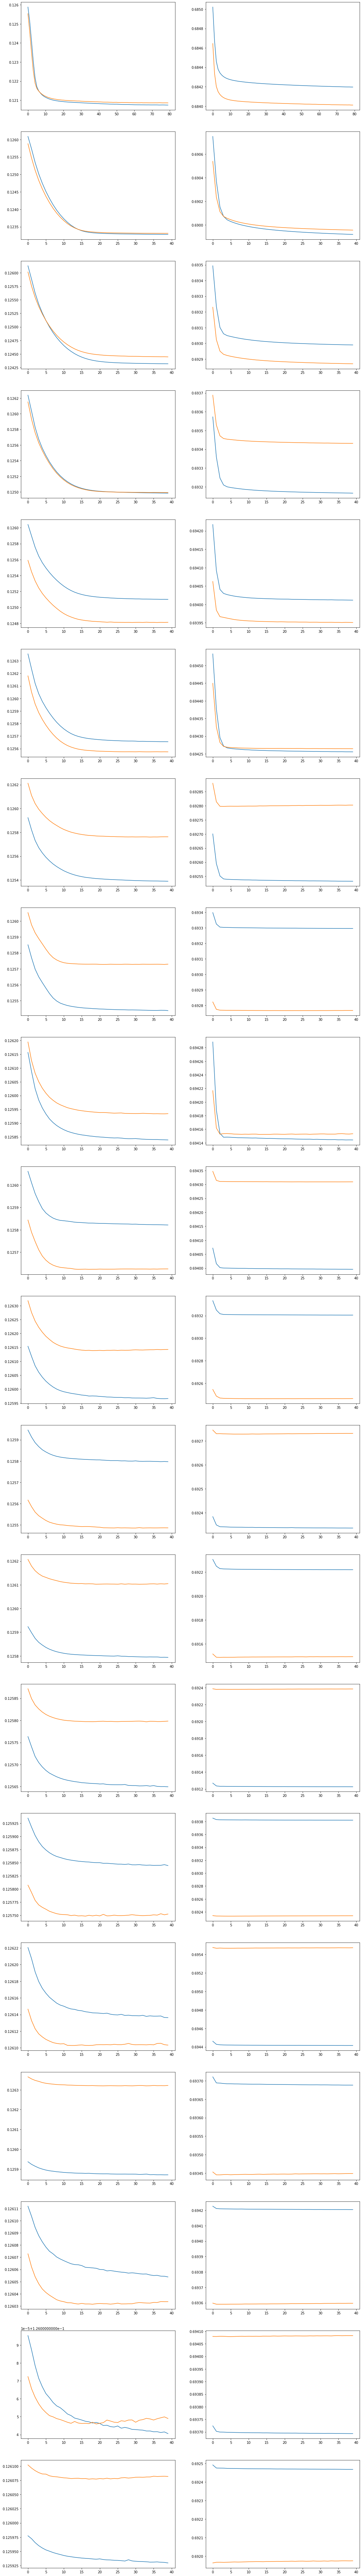

In [22]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

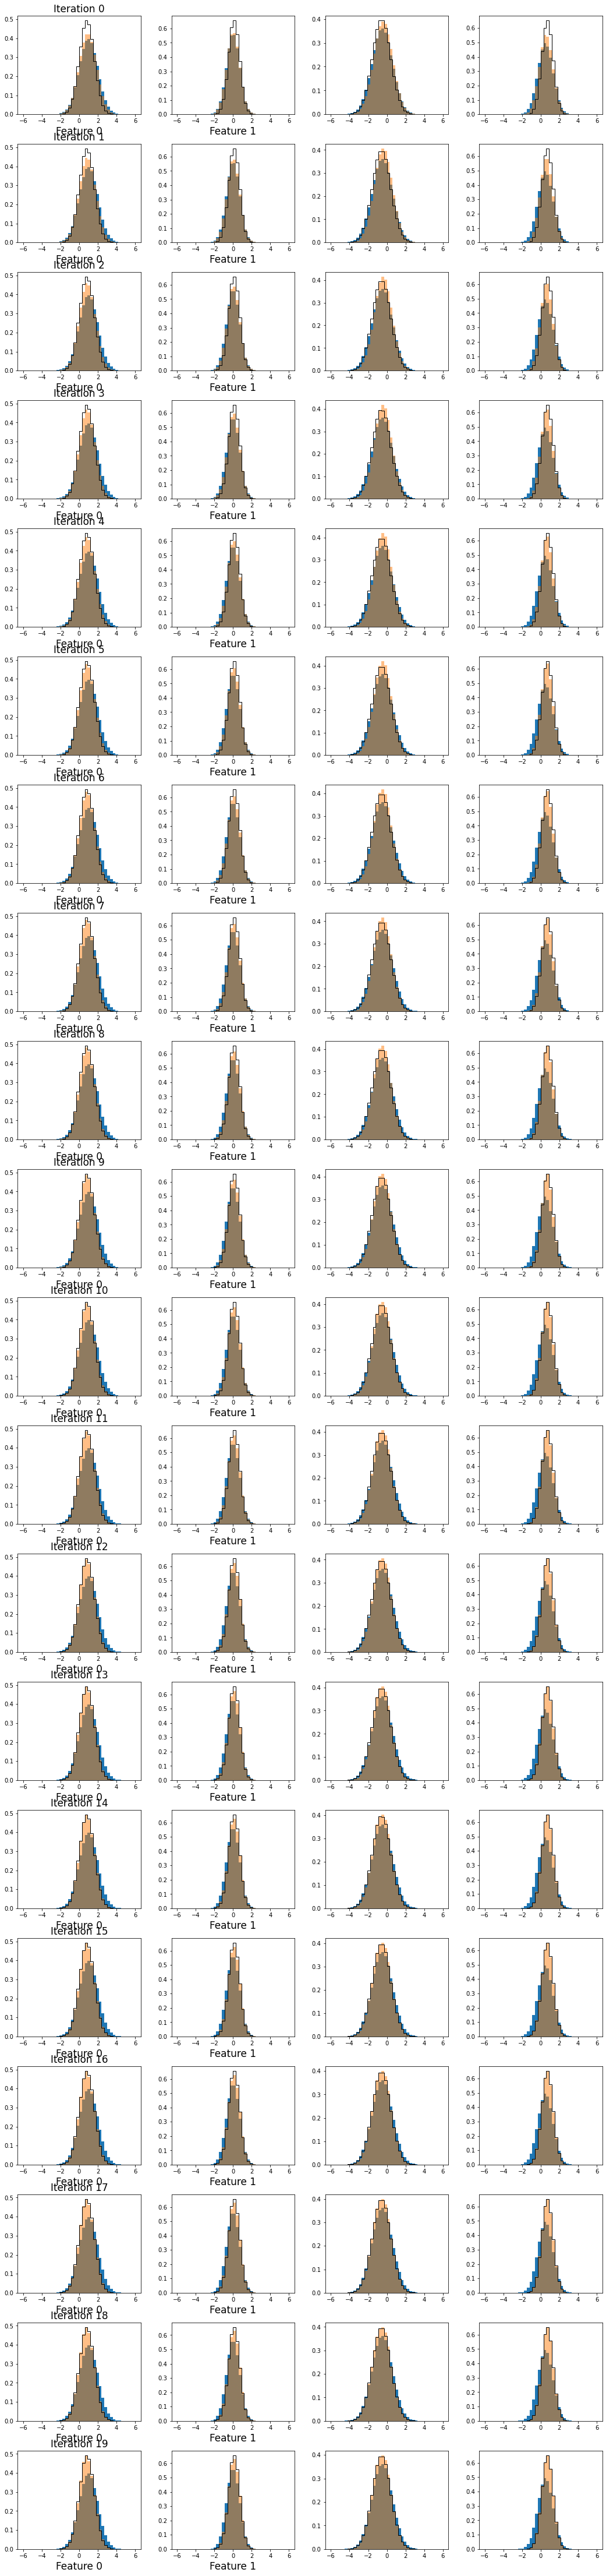

In [23]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :

        
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [24]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

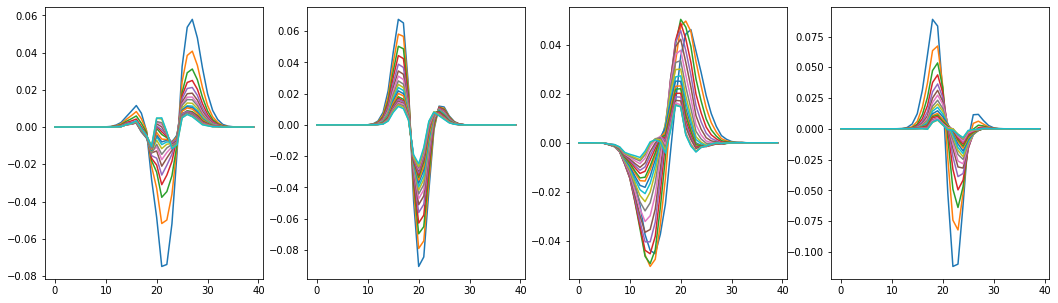

In [25]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

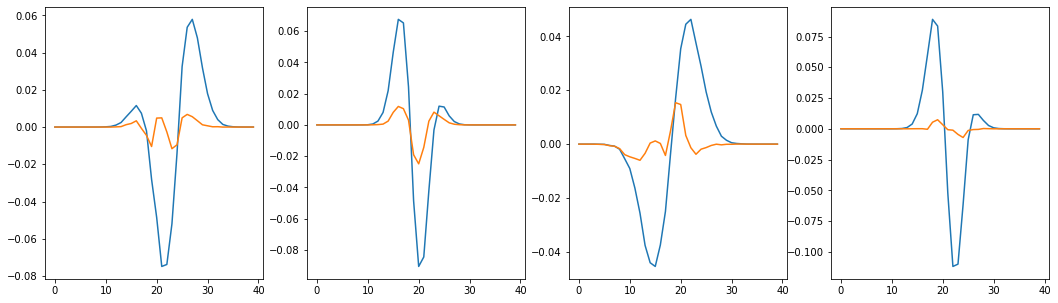

In [26]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

    
plt.show  

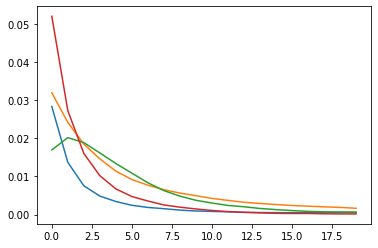

In [27]:
plt.plot( hist_data_sum_diff2)

<function matplotlib.pyplot.show(close=None, block=None)>

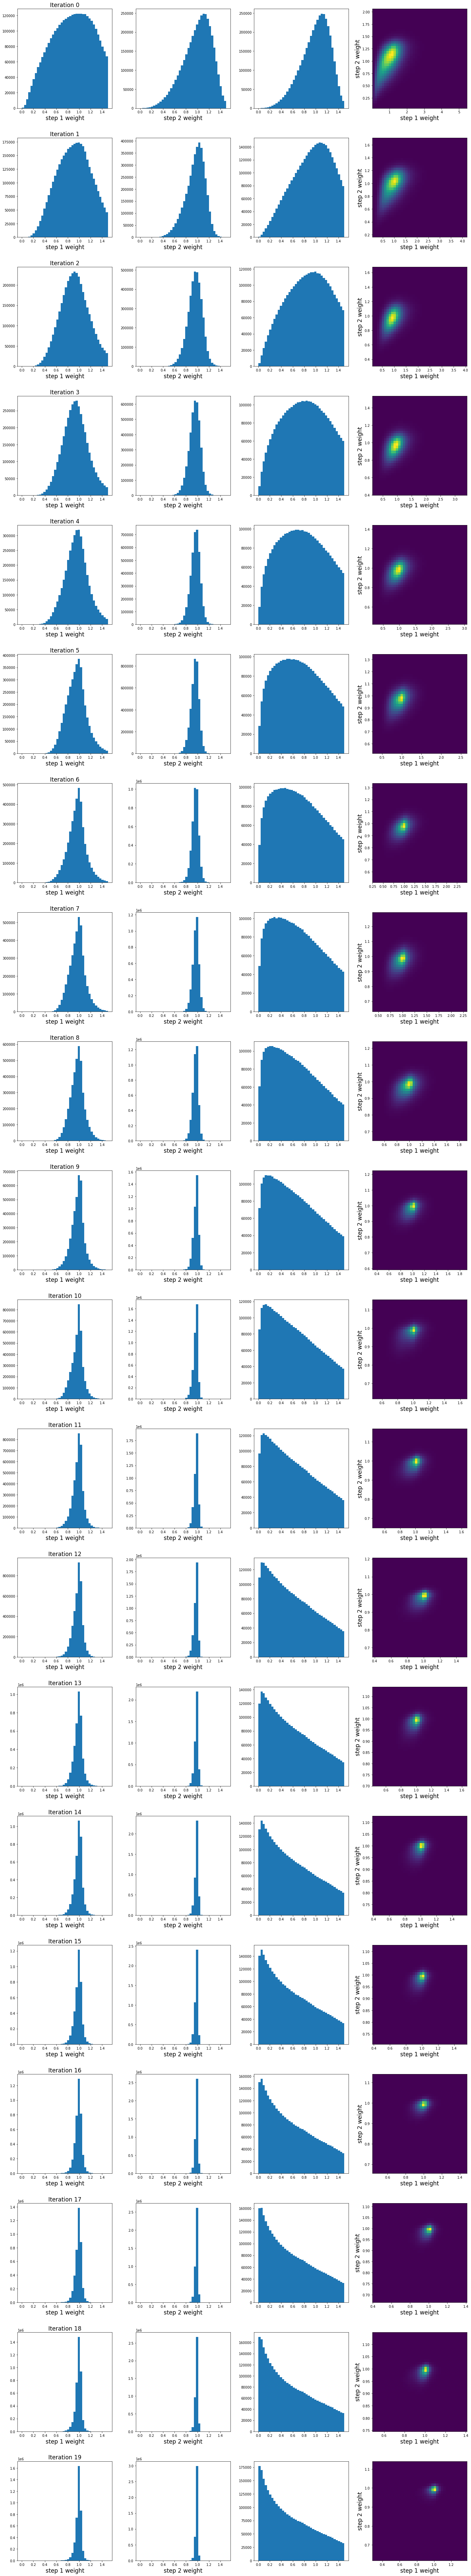

In [28]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

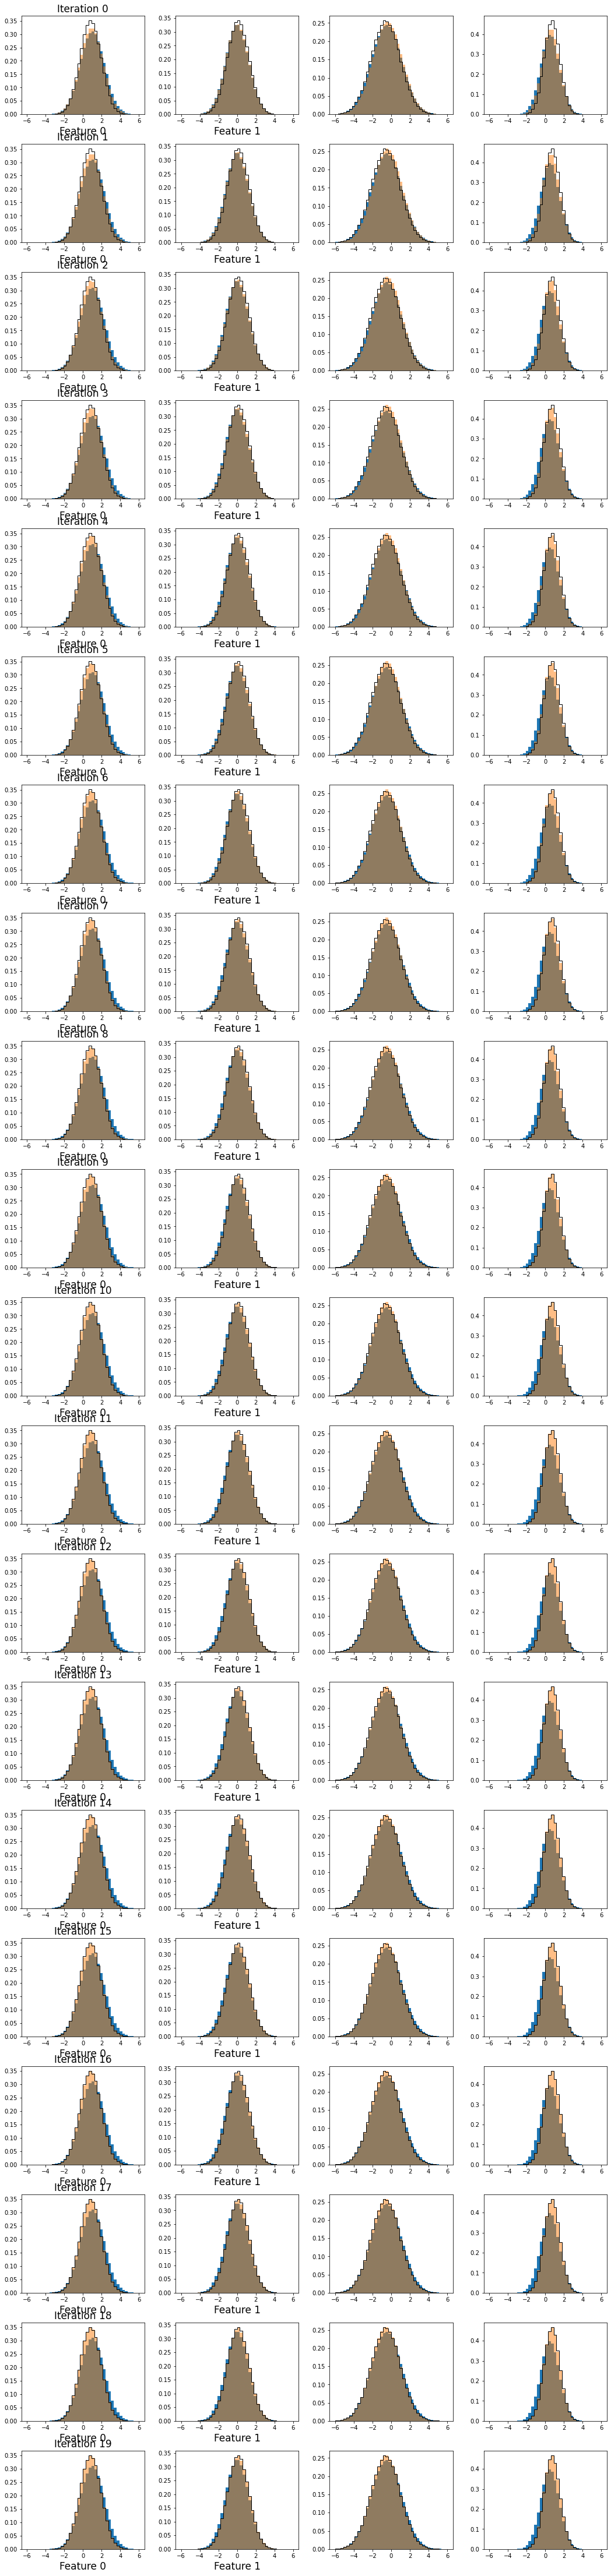

In [29]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :

        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [30]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

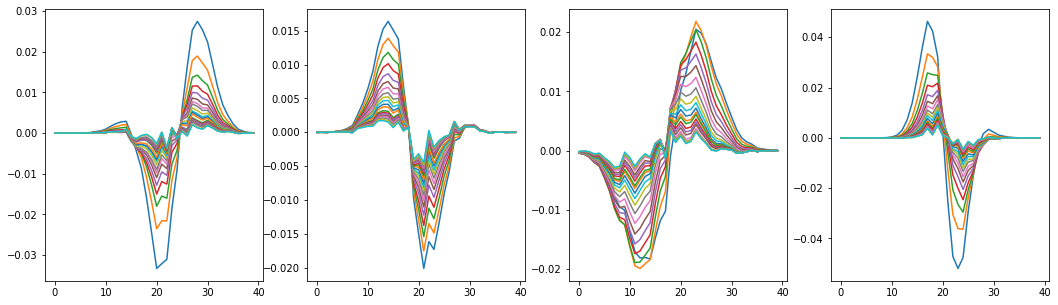

In [31]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

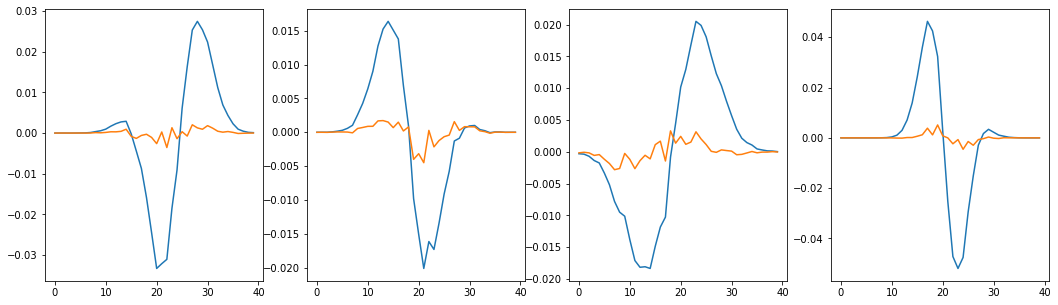

In [32]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show  

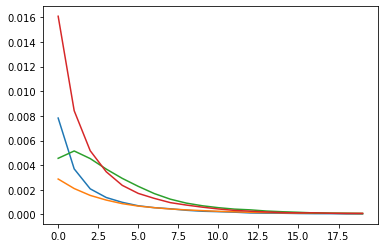

In [33]:
plt.plot( det_hist_data_sum_diff2)

In [34]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.000  rms 0.467      step 2 mean  1.000  rms 0.250
  iter  1 : step 1 mean  0.959  rms 0.349      step 2 mean  0.961  rms 0.169
  iter  2 : step 1 mean  0.954  rms 0.288      step 2 mean  0.956  rms 0.126
  iter  3 : step 1 mean  0.951  rms 0.241      step 2 mean  0.950  rms 0.100
  iter  4 : step 1 mean  0.961  rms 0.215      step 2 mean  0.962  rms 0.086
  iter  5 : step 1 mean  0.954  rms 0.182      step 2 mean  0.954  rms 0.074
  iter  6 : step 1 mean  0.961  rms 0.163      step 2 mean  0.961  rms 0.062
  iter  7 : step 1 mean  0.970  rms 0.143      step 2 mean  0.970  rms 0.055
  iter  8 : step 1 mean  0.966  rms 0.124      step 2 mean  0.965  rms 0.049
  iter  9 : step 1 mean  0.973  rms 0.115      step 2 mean  0.973  rms 0.044
  iter 10 : step 1 mean  0.966  rms 0.099      step 2 mean  0.966  rms 0.041
  iter 11 : step 1 mean  0.977  rms 0.092      step 2 mean  0.978  rms 0.035
  iter 12 : step 1 mean  0.974  rms 0.083      step 2 mean  0.973  rms 0.035

<function matplotlib.pyplot.show(close=None, block=None)>

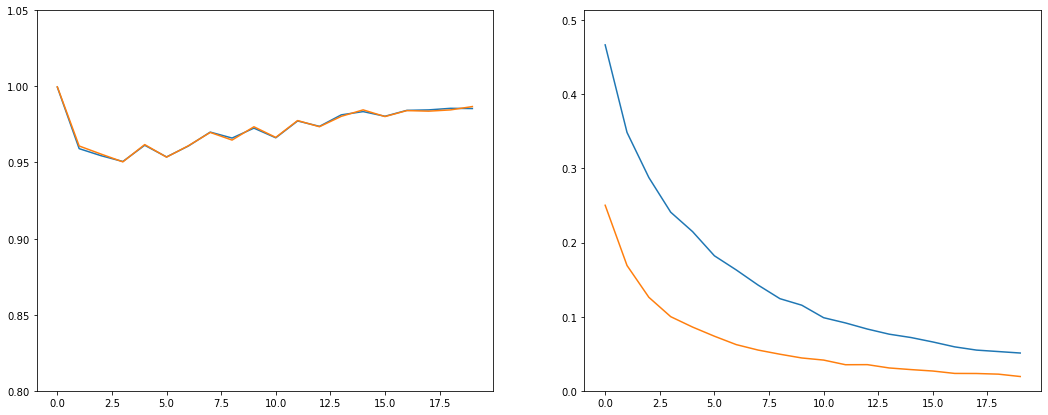

In [35]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show